In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch

import sys, os

from neuralop.utils import count_model_params
from neuralop.models import FNO2d
from neuralop import LpLoss

import torch.nn.functional as F

from models.FNO import FNO2D
from data_transforms.positional_embedding import PositionalEmbedding2D



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()


In [9]:
M = 10
model_list = [FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu) for i in range(M)]

sys.stdout.flush()
save_dir = "./checkpoints_10000_neuralop_bothscaling_500_multi_10"

#load the model if needed
a = 1
if a == 1:
    
    for i in range(0,M): 
        state_dict = torch.load(f"{save_dir}/model_state_{i+1}.pt")
        model_list[i].load_state_dict(state_dict)

train_loss = LpLoss(d = 2, p = 2, reductions = "sum")

In [10]:
from neuralop.datasets.output_encoder import UnitGaussianNormalizer
from sklearn.preprocessing import RobustScaler
x_train = torch.load('../../data_poisson/dirichlet_10000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../../data_poisson/dirichlet_10000_32_y.pt').clone().type(torch.FloatTensor)
y_train = y_train.unsqueeze(1)



reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(dim = reduce_dims)
input_encoder.fit(x_train)
# print(input_encoder.mean, input_encoder.std)

reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim = reduce_dims)
output_encoder.fit(y_train)


x_train = input_encoder.transform(x_train)
y_train = output_encoder.transform(y_train)

# input_scaler = RobustScaler()
# output_scaler = RobustScaler()
# x_train = x_train.view(x_train.shape[0],-1)
# y_train = y_train.view(y_train.shape[0],-1)
# x_train = torch.tensor(input_scaler.fit_transform(x_train).reshape(x_train.shape[0],1,32,32)).type(torch.FloatTensor)
# y_train = torch.tensor(output_scaler.fit_transform(y_train).reshape(y_train.shape[0],1,32,32)).type(torch.FloatTensor)


grid_boundaries = [[0,1],[0,1]]


x_train = PositionalEmbedding2D([[0,1],[0,1]])(x_train)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )

train_loader_list = [train_loader for i in range(M)]


In [33]:
#test set
x_test = torch.load('../../data_poisson/dirichlet_test_100_32_x.pt').clone()
y_test = torch.load('../../data_poisson/dirichlet_test_100_32_y.pt').clone()

y_test = y_test.unsqueeze(1)



#x_test = x_test.view(x_test.shape[0],-1)
#y_test = y_test.view(y_test.shape[0],-1)
#x_test = torch.tensor(input_encoder.transform(x_test).reshape(x_test.shape[0],1,32,32)).type(torch.FloatTensor)
## y_test = torch.tensor(output_scaler.transform(y_test).reshape(y_test.shape[0],1,32,32)).type(torch.FloatTensor)

#x_test = input_encoder.transform(x_test)

#y_test = output_encoder.transform(y_test)

#x_test = PositionalEmbedding2D([[0,1],[0,1]])(x_test)



test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )


test_loader_list = [test_loader for i in range(M)]

eval_loss = train_loss

(32, 32)


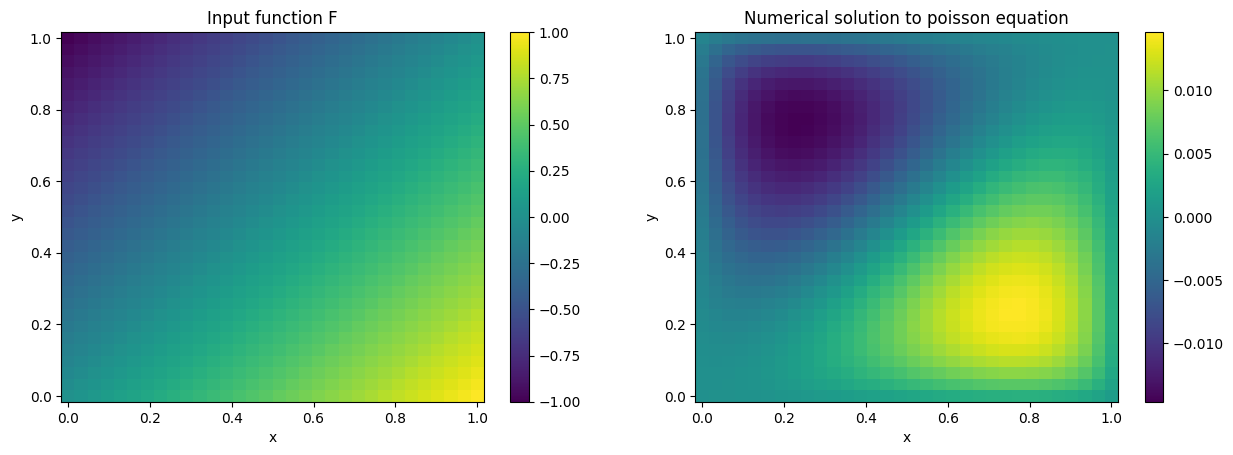

torch.Size([1, 1, 32, 32])


In [12]:
#the function
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

N = 32
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X -0.5) * np.abs(Y-0.5)
print(F.shape)
#F = np.sin(X)*np.sin(Y)/np.sqrt(2*np.pi**2) - np.sin(2*X) * np.sin(Y) / np.sqrt(5*np.pi**2)
F = X-Y
#F = X**2 + Y**2
#for i in range(1,200):
    #F+= np.random.normal(0,10) *np.sin(i*X) * np.sin(i*Y) / np.sqrt((2*i**2)*np.pi**2)
#F = (X-0.5) * (Y-0.5)

#F = np.abs(X -0.25) * np.abs(Y-0.25) * np.abs(X +0.25) * np.abs(Y+0.25)


F*=1

#redefine for numerical solver, which solves Lu = f, so have to redefine
def solver(F, neumann,N):
    F_num = -F
    # Initialize the sparse matrix A
    main_diagonal = np.ones(N**2) * -4 / h**2
    offset_diagonals = np.ones(N**2 - 1) / h**2
    offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
    far_diagonals = np.ones(N**2 - N) / h**2

    # Create the sparse matrix A using diags
    A = sp.diags(
        [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
        [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')
    if neumann:

        for i in range(N):
            if i == 0 or i == N-1:
                A[i,:] = A[-(i+1),:] = 0
                A[i,i] = A[-(i+1),-(i+1)] = 1/h
            if i % N == 0 or (i+1) % N == 0:
                A[i,:] = 0
                A[i,i] = 1/h

    F_num = F_num.ravel()

    if neumann:
        F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

    # Solve the linear system
    u = scipy.sparse.linalg.spsolve(A, F_num)
    U = u.reshape((N, N))
    return U

U = solver(F,neumann,N)


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [23]:


def evaluator(model_list,sample):

    for i in range(M): model_list[i].eval().to(device) 

    sample_scaled = input_encoder.transform(sample.type(torch.FloatTensor))
    sample_scaled = PositionalEmbedding2D(grid_boundaries=grid_boundaries)(sample_scaled).to(device)

    out = [model_list[i](sample_scaled).to(device) for i in range(M)]
    #return to original scale
    out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

    mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
    var_unseen = torch.mean(torch.stack([torch.square(out[i] - mu_unseen) for i in range(M)], dim = 0),dim=0)
    return mu_unseen, var_unseen



C:\Users\frase\AppData\Local\Temp\ipykernel_5484\655792342.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


Max variance for the spike: 0.00034171887091360986


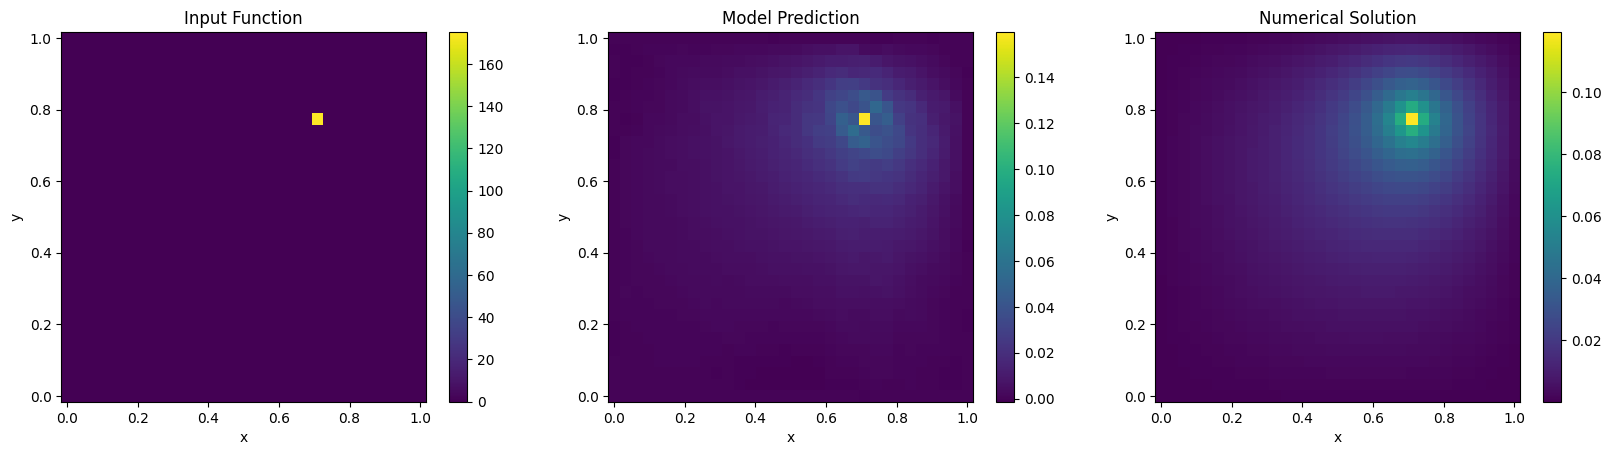

In [59]:
from plotting.results_plotter import plotter

#make a random spike
sample = torch.zeros((32,32))
idx = np.random.randint(0,32**2,1)
sample[idx//32,idx%32] = 175



U = solver(sample,neumann,N)
U = torch.tensor(U).clone().to(device)

mu_spike, var_spike = evaluator(model_list,sample)
print(f"Max variance for the spike: {torch.max(var_spike).item()}")
plotter(sample,mu_spike,U,X,Y)



C:\Users\frase\AppData\Local\Temp\ipykernel_5484\655792342.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


Max variance for the spike: 2.667138119250012e-07
Loss: 0.24303251453998087


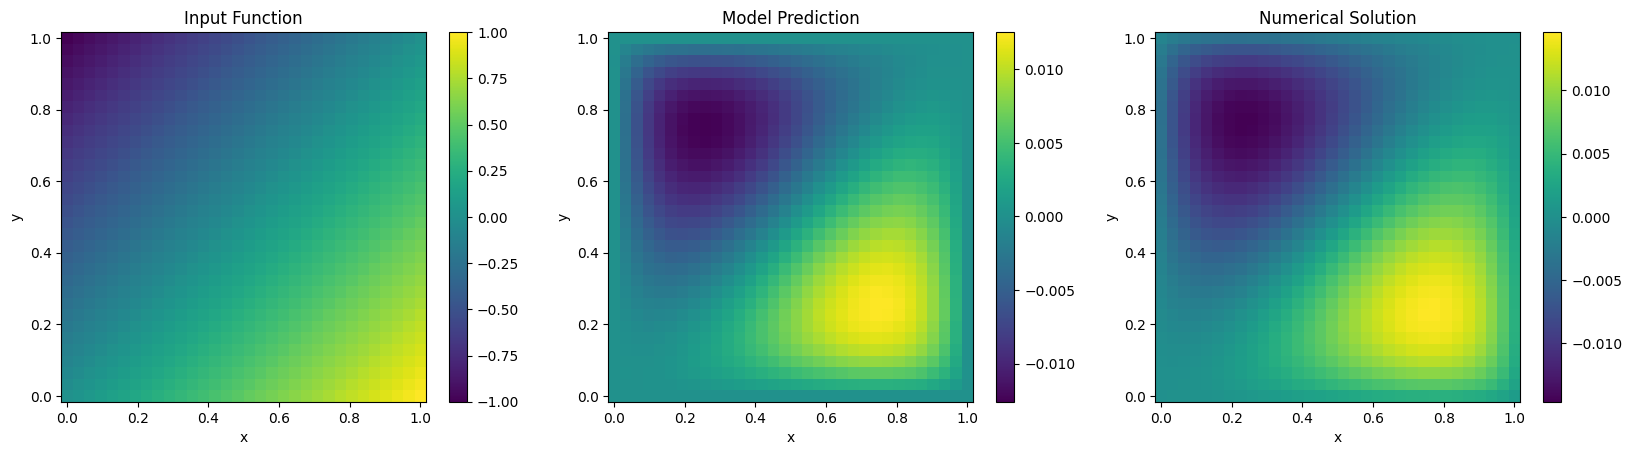

In [130]:
F = X-Y
F = torch.tensor(F)[None,None,:]
F*=1
U = solver(F,neumann,N)
U = torch.tensor(U).clone().to(device)

mu_F, var_F = evaluator(model_list,F)
print(f"Max variance for the spike: {torch.max(var_F).item()}")
print(f"Loss: {train_loss(mu_F,U).item()}")
plotter(F[0,0,:,:],mu_F,U,X,Y)

C:\Users\frase\AppData\Local\Temp\ipykernel_5484\655792342.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


Max variance for the test: 1.3699973351322114e-05
Loss: 0.008939485065639019


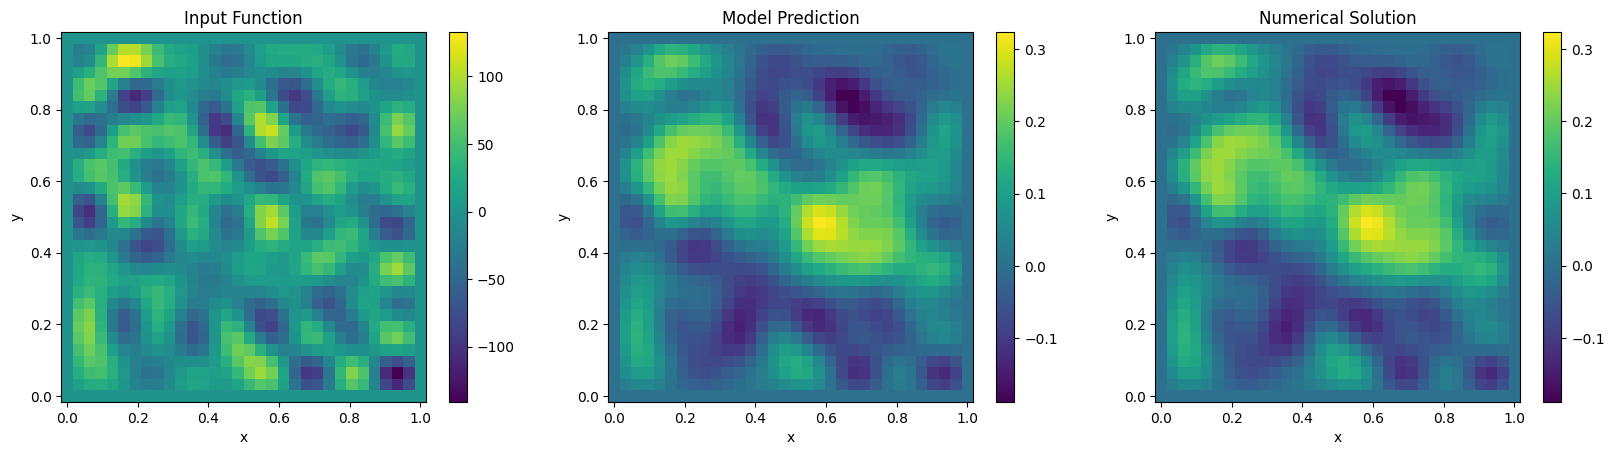

In [135]:
#test set element
i = np.random.randint(0,100)
j = np.random.randint(0,100)

#for the purposes of testing, we reimport the test loader so it is not transformed

sample = test_loader.dataset[i][0].unsqueeze(0).to(device)
solution = test_loader.dataset[i][1].unsqueeze(0)

mu_test, var_test = evaluator(model_list,sample)

print(f"Max variance for the test: {torch.max(var_test).item()}")
print(f"Loss: {train_loss(mu_test.cpu(),solution.cpu()).item()}")
plotter(sample[0,0,:,:],mu_test,solution[0,0,:,:],X,Y)    

In [1]:
sample = torch.rot90(sample,1,[2,3])


mu_test_rot, var_test_rot = evaluator(model_list,sample)

solution = torch.rot90(solution,1,[2,3])

print(f"Max variance for the test: {torch.max(var_test_rot).item()}")
print(f"Loss: {train_loss(mu_test_rot.cpu(),solution.cpu()).item()}")
plotter(sample[0,0,:,:],mu_test_rot,solution[0,0,:,:],X,Y) 

NameError: name 'torch' is not defined

In [2]:
a = torch.rand((10,1,32,32))
from layers.spectralconv import SpectralConv2D

conv = SpectralConv2D(12,1,1)
conv(a)

xft torch.Size([10, 1, 32, 17])
torch.Size([10, 1, 12, 12])
torch.Size([10, 1, 32, 32])


tensor([[[[0.3302, 0.4321, 0.2806,  ..., 0.4270, 0.3020, 0.1213],
          [0.4231, 0.3368, 0.1279,  ..., 0.4573, 0.2177, 0.1685],
          [0.4166, 0.2346, 0.3269,  ..., 0.3619, 0.1423, 0.2702],
          ...,
          [0.3515, 0.3957, 0.2251,  ..., 0.4161, 0.4180, 0.2917],
          [0.2450, 0.2537, 0.1904,  ..., 0.2826, 0.3675, 0.2226],
          [0.2211, 0.3162, 0.3374,  ..., 0.3096, 0.3601, 0.1383]]],


        [[[0.3247, 0.2744, 0.3191,  ..., 0.2343, 0.2378, 0.2491],
          [0.3505, 0.5003, 0.5781,  ..., 0.1965, 0.2612, 0.2288],
          [0.4985, 0.5638, 0.3627,  ..., 0.3765, 0.3792, 0.3236],
          ...,
          [0.2662, 0.2447, 0.3249,  ..., 0.2767, 0.2077, 0.1725],
          [0.2724, 0.4436, 0.4662,  ..., 0.2409, 0.1475, 0.0999],
          [0.4257, 0.4301, 0.2165,  ..., 0.2466, 0.1811, 0.2164]]],


        [[[0.3037, 0.4683, 0.5166,  ..., 0.2925, 0.3647, 0.2588],
          [0.3938, 0.4527, 0.2872,  ..., 0.5236, 0.3769, 0.2833],
          [0.3352, 0.2711, 0.1208,  ..